In [1]:
# Disable warnings

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import scipy.stats as stats
from pydataset import data

# acquire
from env import host, user, password

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.model_selection import learning_curve

import my_wrangle_zillow

# Exercises

### Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror.
- e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

2. Answer those questions through a mix of statistical tests and visualizations.

### Bonus:

- Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [2]:
# 1. univariate explorate
# - What are the distributions of each variable? 

# 2. Bivariate:
# - Does logerror score vary across fips?

# 3. Bivariate:
# - Is there a relationship between lotsizesquarefeet and logerror?

# 4. Is there a relationship between latitude and logerror?

# multivariate:
# 5. If we control for calculatedfinishedsqft, does logerror differ across fips?

# 6. If we control for yearbuilt, does logerror differ across latitudes?

In [3]:
# acquire and prep data using functions from wrangle

df = my_wrangle_zillow.prepare_zillow(my_wrangle_zillow.get_zillow_data())
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
6,781532,12095076,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,...,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Single Family Residential


In [4]:
#Look at column names

df.columns.tolist()

['id',
 'parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror',
 'transactiondate',
 'propertylandusedesc']

In [5]:
#spilt function

def split_zillow(df, target):
    '''
    this function takes in the zillow dataframe
    splits into train, validate and test subsets
    then splits for X (features) and y (target)
    '''
    # split df into 20% test, 80% train_validate
    train_validate, test = train_test_split(df, test_size=0.2, random_state=1234)
    # split train_validate into 30% validate, 70% train
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=1234)
    # Split with X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [6]:
# Using split function

train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_zillow(df, 'logerror')

### 1. Univariate explorate
 - What are the distributions of each variable? 

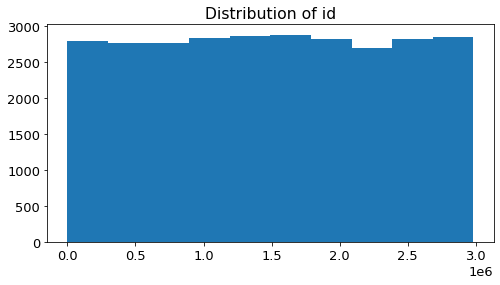

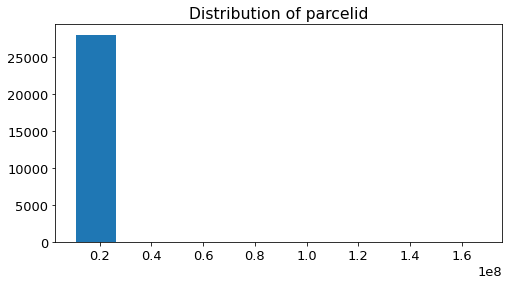

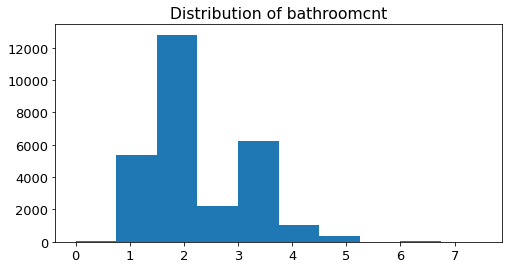

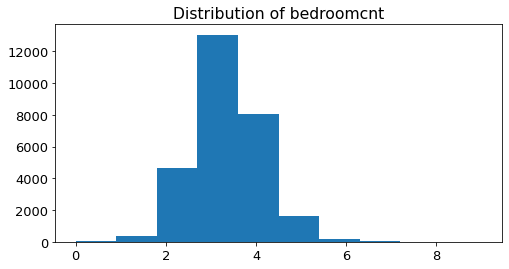

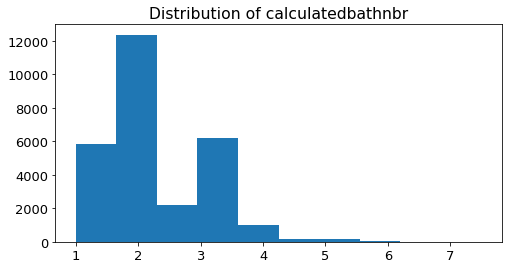

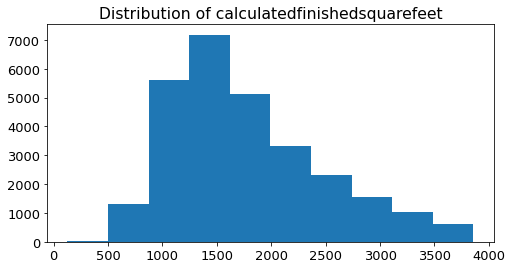

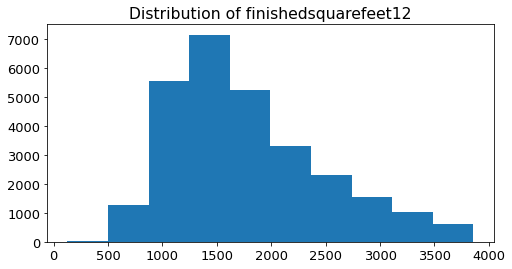

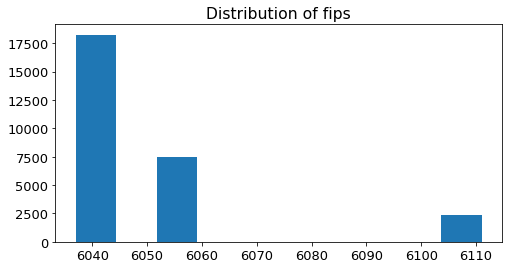

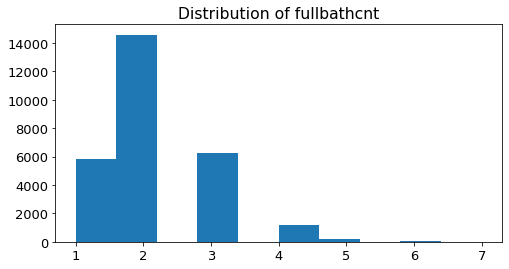

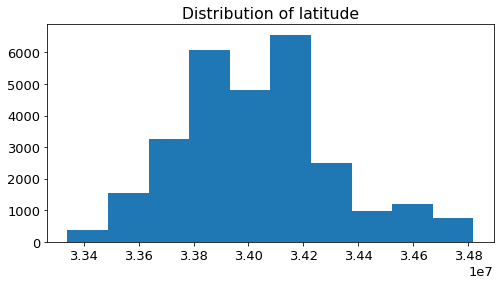

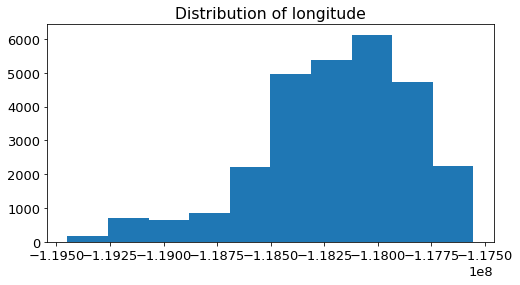

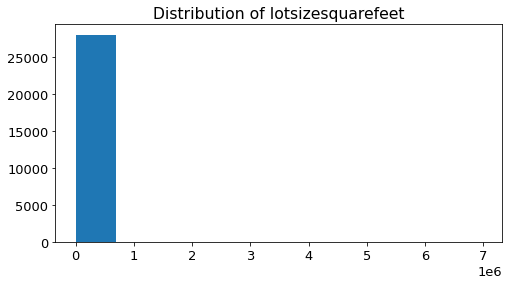

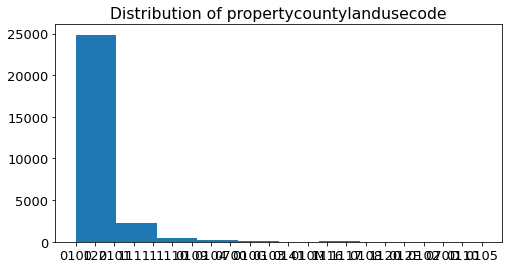

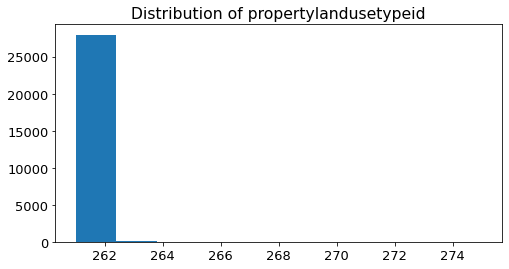

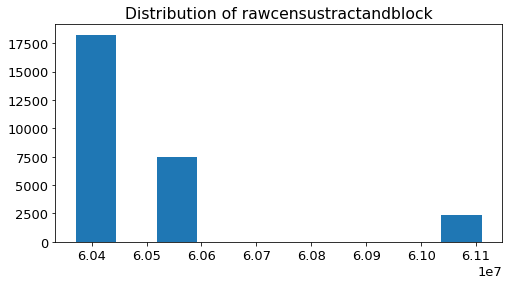

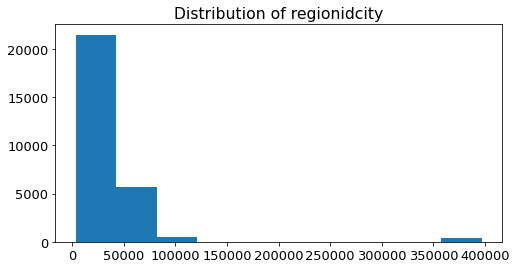

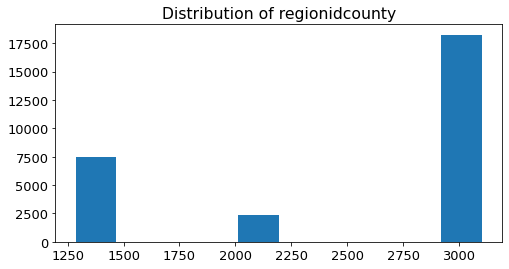

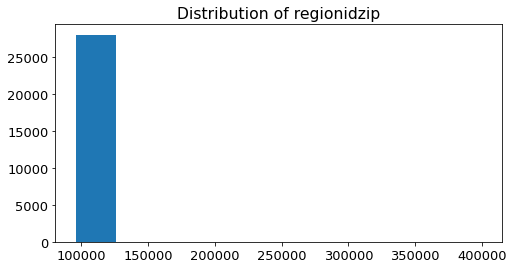

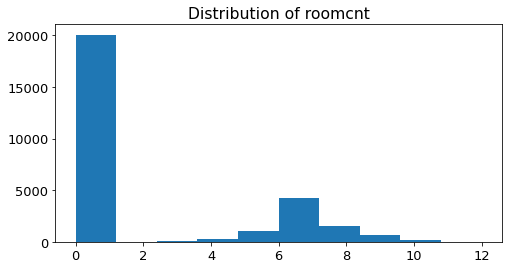

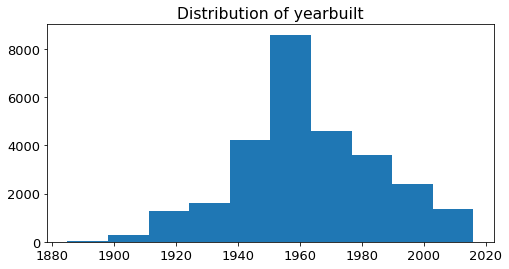

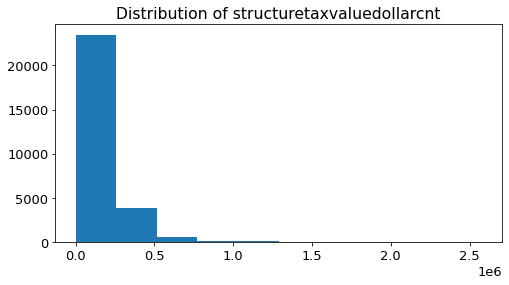

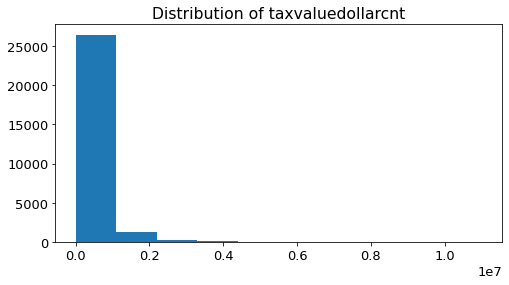

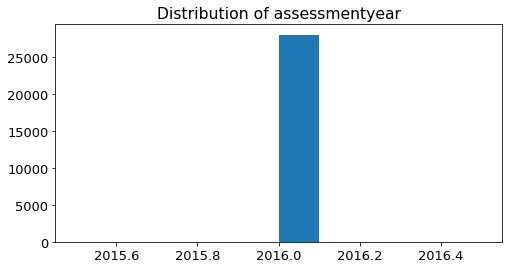

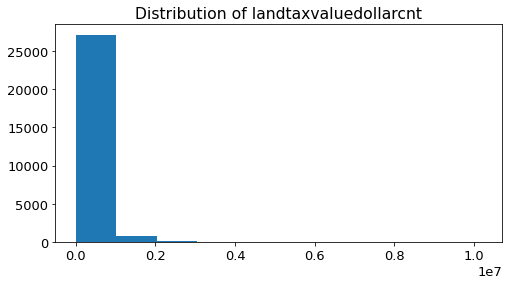

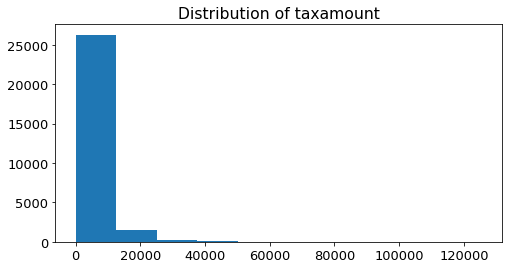

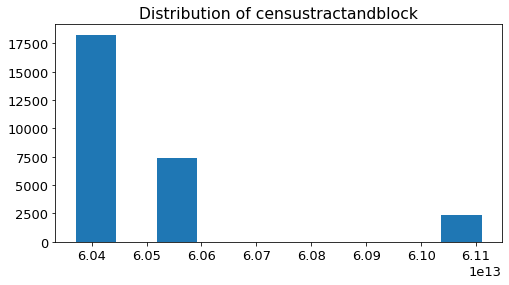

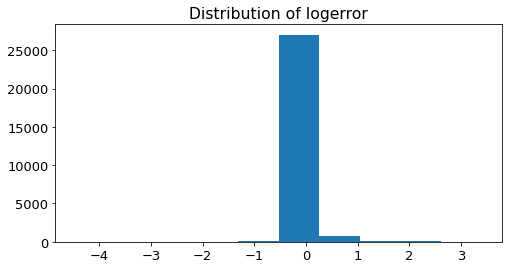

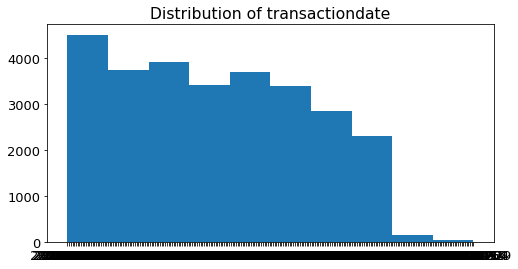

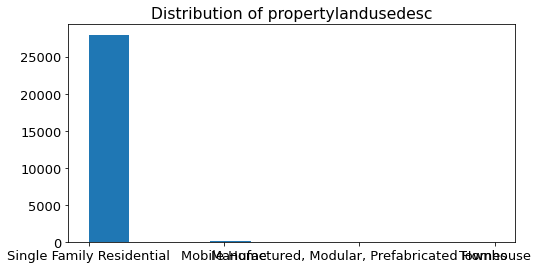

In [7]:
for col in train.columns:
    plt.figure(figsize=(8,4))
    plt.hist(train[col])
    plt.title(f'Distribution of {col}')
    plt.show()

- Takeways:
    - most of the variables do not seem to have normal distribution except for Latitude.


### 2. Bivariate:
 - Does logerror score vary across fips?
 - continous (logerror) and fips (categorical)
 - two sample, two tailed t-tests

In [8]:
# test the assumption of equal variance

stats.levene(train[train.fips <= 6037].logerror, 
             train[train.fips > 6037].logerror
            )

LeveneResult(statistic=30.96816618690475, pvalue=2.6469061344356262e-08)

In [9]:
# Mannwhiteneyu test (a type of t-test when not normally distributed)

group1 = train[train.fips <= 6037]['logerror']
group2 = train[train.fips > 6037]['logerror']

t, p= stats.mannwhitneyu(group1, group2)

In [10]:
alpha= 0.05

null = 'There is no difference in means between fips and logerror'

if p < alpha:
    print(f' we reject the null hypotheis,  {null}')
else:
    print(f' we do not reject the null hypothesis, {null}')

 we reject the null hypotheis,  There is no difference in means between fips and logerror


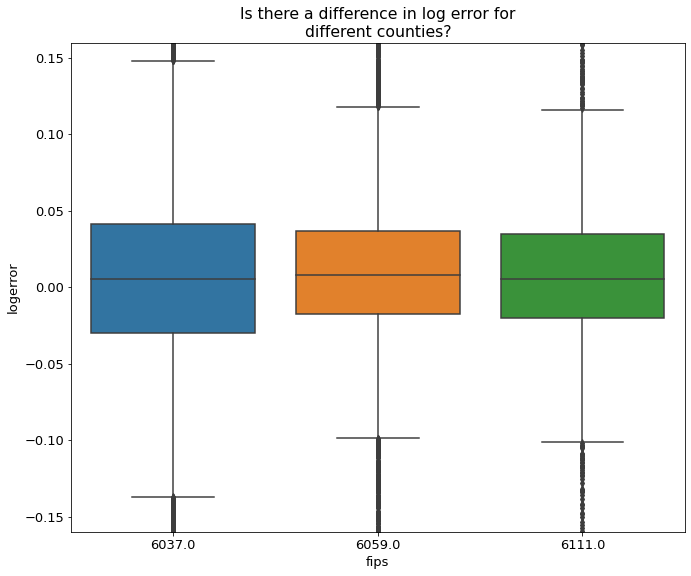

In [11]:
sns.boxplot(train.fips, train.logerror)
plt.title("Is there a difference in log error for\ndifferent counties?")
plt.ylim(-0.16, 0.16)
plt.show()

### 3. Bivariate:
- Is there a relationship between lotsizesquarefeet and logerror?
- continous (logerror) and continous (lotsizesquarefeet)
- pearson r correlation stats test

In [12]:
corr, p2 = stats.pearsonr(train.logerror, train.lotsizesquarefeet)
print(corr,p2)

0.009256014886638218 0.12117274456741559


            Logerror vs finishedsquareft


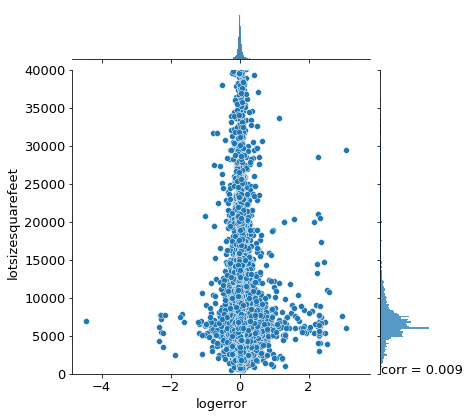

In [13]:
print('           ', 'Logerror vs finishedsquareft')
sns.jointplot(x = 'logerror', y = 'lotsizesquarefeet',data = train)
plt.ylim(0,40000)
plt.text(8, 80, f'corr = {corr:.3f}')
plt.show()

In [14]:
alpha= 0.05

null = 'There is no relationship between lotsizesquarefeet and logerror'

if p2 < alpha:
    print(f' we reject the null hypotheis,  {null}')
else:
    print(f' we do not reject the null hypothesis, {null}')

 we do not reject the null hypothesis, There is no relationship between lotsizesquarefeet and logerror


### 4. Bivariate:
- Is there a relationship between latitude and logerror?
- latitude (continous) and logerror (continous)
- pearson r correlation stats test

In [15]:
corr, p3 = stats.pearsonr(train.logerror, train.latitude)
print(corr,p3)

-0.016136573203993764 0.006890294808201246


<function matplotlib.pyplot.show(close=None, block=None)>

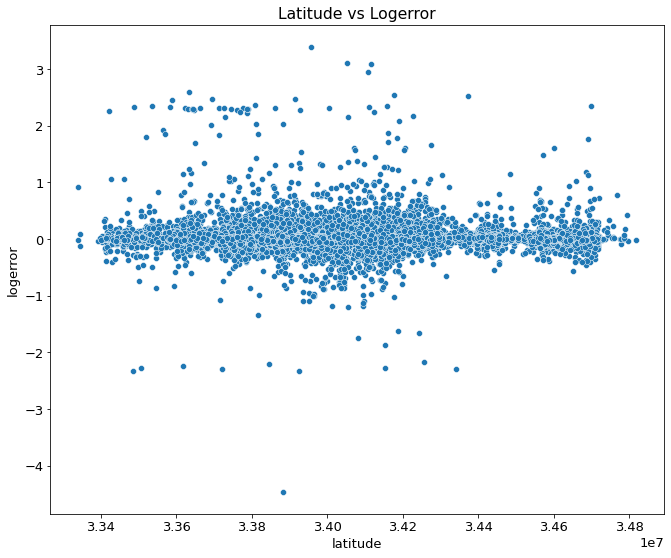

In [16]:
sns.scatterplot(x='latitude', y = 'logerror', data= train)
plt.title('Latitude vs Logerror')
plt.show

In [17]:
alpha= 0.05

null = 'There is no relationship between latitude and logerror'

if p3 < alpha:
    print(f' we reject the null hypotheis,  {null}')
else:
    print(f' we do not reject the null hypothesis, {null}')

 we reject the null hypotheis,  There is no relationship between latitude and logerror


### Multivariate:
### 5. If we control for calculatedfinishedsqft, does logerror differ across fips?

- Note: only do visuals for multivariate

In [18]:
train['calculatedfinishedsquarefeet'].describe()

count    28039.000000
mean      1772.402618
std        696.040302
min        128.000000
25%       1249.000000
50%       1612.000000
75%       2174.000000
max       3857.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [19]:
train['calculatedfinishedsqft_bin'] = pd.cut(train.calculatedfinishedsquarefeet, [0,2000,3900])

In [20]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc,calculatedfinishedsqft_bin
70512,942844,11279773,1.0,3.0,1.0,1452.0,1452.0,6037.0,1.0,34676381.0,...,69182.0,86475.0,2016.0,17293.0,1818.92,6.037901e+13,-0.202871,2017-08-28,Single Family Residential,"(0, 2000]"
39551,2169880,12434969,1.0,2.0,1.0,1274.0,1274.0,6037.0,1.0,33823051.0,...,35638.0,74133.0,2016.0,38495.0,979.52,6.037574e+13,0.204393,2017-05-25,Single Family Residential,"(0, 2000]"
24158,2270471,11421274,1.0,2.0,1.0,840.0,840.0,6037.0,1.0,33904365.0,...,23441.0,246457.0,2016.0,223016.0,3254.68,6.037602e+13,-0.034953,2017-04-07,Single Family Residential,"(0, 2000]"
15861,1233642,13927785,2.0,3.0,2.0,2043.0,2043.0,6059.0,2.0,33777242.0,...,102619.0,133912.0,2016.0,31293.0,1825.70,6.059110e+13,-0.027147,2017-03-09,Single Family Residential,"(2000, 3900]"
66524,1579034,14503679,3.0,4.0,3.0,1882.0,1882.0,6059.0,3.0,33649044.0,...,152273.0,296741.0,2016.0,144468.0,3004.14,6.059032e+13,0.031396,2017-08-15,Single Family Residential,"(0, 2000]"


In [21]:
train.calculatedfinishedsqft_bin.value_counts()

(0, 2000]       19320
(2000, 3900]     8719
Name: calculatedfinishedsqft_bin, dtype: int64

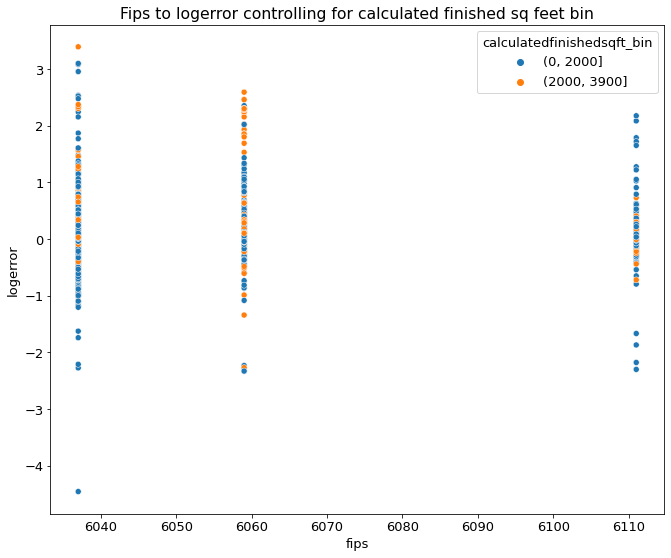

In [22]:
sns.scatterplot(x='fips', y='logerror', data= train, hue= 'calculatedfinishedsqft_bin')
plt.title('Fips to logerror controlling for calculated finished sq feet bin')
plt.show()

### 6. If we control for yearbuilt, does logerror differ across latitudes?

In [23]:
train.yearbuilt.describe()

count    28039.000000
mean      1962.434217
std         22.419598
min       1885.000000
25%       1950.000000
50%       1960.000000
75%       1977.000000
max       2016.000000
Name: yearbuilt, dtype: float64

In [24]:
train['year_built_bin'] = pd.cut(train.yearbuilt, [1865, 1960, 2016])

In [25]:
train.year_built_bin.value_counts()

(1865, 1960]    14464
(1960, 2016]    13575
Name: year_built_bin, dtype: int64

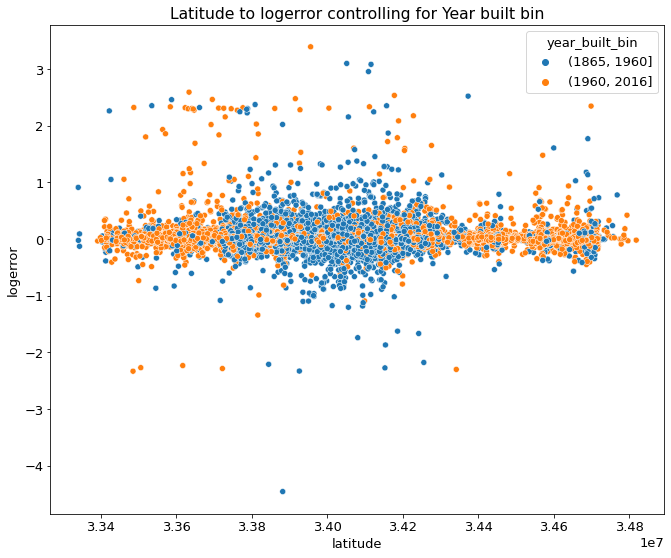

In [26]:
sns.scatterplot(x='latitude', y='logerror', data= train, hue= 'year_built_bin')
plt.title('Latitude to logerror controlling for Year built bin')
plt.show()

### Bonus:

- Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [30]:
train.fips.value_counts()

6037.0    18244
6059.0     7439
6111.0     2356
Name: fips, dtype: int64

In [31]:
# 6111 = Ventura
# 6037 = Los Angeles
# 6059 = Orange

In [32]:
train['county'] = train.fips.apply(lambda x: 'orange' if x == 6059.0 else 'los_angeles' if x == 6037.0 else 'ventura')

In [33]:
train.county.value_counts()

los_angeles    18244
orange          7439
ventura         2356
Name: county, dtype: int64

In [34]:
fips_with_significantly_different_errors = []
zips = train.county.unique()

In [35]:
zips

array(['los_angeles', 'orange', 'ventura'], dtype=object)

In [36]:
population_logerror_mean = train.logerror.mean()

In [37]:
for zipc in zips:
    t, p = stats.ttest_1samp(train[train.county == zipc].logerror, population_logerror_mean)
    if p < 0.05:
        fips_with_significantly_different_errors.append(zipc)

In [38]:
fips_with_significantly_different_errors

['los_angeles', 'orange']